# Modelings

`Precision` -> What proportion of positive identifications was actually correct? For example when `precision = 0.5`, it means when it predicts a people is bipolar, it is correct 50% of the time
$$\frac{TP}{TP+FP}$$

`Recall` -> What proportion of actual positives was identified correctly? For example when `recall = 0.75`, it correctly identifies 75% of all bipolar people.
$$\frac{TP}{TP+FN}$$

`F1 Score` -> is the harmonic mean of precision and recall
$$2 \times \frac{precision \times recall}{precision+recall}$$

## Import Library

In [164]:
import numpy as np
import pandas as pd
import glob

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.ensemble import BaggingClassifier, VotingClassifier
import joblib

from helpers.preprocessing import PreProcessing

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
data = pd.read_csv('data/data_vectorizer.csv')
label_encoder = LabelEncoder()
data['disorder_label'] = label_encoder.fit_transform(data['disorder'])
x = data.drop(['disorder', 'disorder_label'], axis=1).to_numpy()
y = data['disorder_label'].to_numpy()

## Simple Tuner Class

In [128]:
class Tuner():
    def __init__(
        self, x, y, clf, params, 
        cv=StratifiedKFold(n_splits=10, random_state=27, shuffle=True), 
        refit='recall'
    ):
        self._clf_base = clf
        self._clf_name = self._get_clf_name(clf)
        self.params = params
        self.cv = cv
        self.x = x
        self.y = y
        self.refit = refit
        self.__summary = None
        self.__fit()
        
    def _get_clf_name(self, clf):
        return str(type(clf)).split("'")[1].split('.')[-1]
    
    def metrics(self, clf, x, y):
        y_pred = clf.predict(x)
        reports = classification_report(y, y_pred, output_dict=True)
        report = reports['0']
        report['accuracy'] = reports['accuracy']    
        return reports['0']
    
    @property
    def summary(self):
        if self.__summary is None:
            selected_columns = ['clf_name', 'params', 'mean_test_precision', 'std_test_precision', 
                                'mean_test_recall', 'std_test_recall', 'mean_test_f1-score', 
                                'std_test_f1-score', 'mean_test_accuracy', 'std_test_accuracy', 
                                'mean_fit_time', 'std_fit_time']
            self.__summary = pd.DataFrame(self.clf.cv_results_)
            self.__summary['clf_name'] = self._clf_name
            self.__summary = self.__summary[selected_columns] 
        
        return self.__summary
    
    def __summary_sort(self, type):
        summary = self.summary
        columns = summary.columns
        selected_columns = ['clf_name', 'params']
        selected_columns += list(columns[columns.str.startswith(type)])
        return summary[selected_columns]
    
    @property
    def summary_mean(self):
        return self.__summary_sort('mean')
    
    @property 
    def summary_std(self):
        return self.__summary_sort('std')
        
    def __fit(self):
        self.clf = GridSearchCV(
            self._clf_base, self.params, 
            scoring=self.metrics, cv=self.cv, refit=self.refit
        )
        self.clf.fit(self.x, self.y)

## Baseline Model

In [137]:
parameters = {'strategy' : ['most_frequent', 'uniform', 'stratified']}
tuner_baseline= Tuner(
    x, y, clf=DummyClassifier(),
    params=parameters
)

In [138]:
tuner_baseline.summary.to_csv('report/baseline.csv')

## Random Forest

In [135]:
parameters = {
    'n_estimators' : np.arange(50, 501, step=50),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5, 10],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf' : [1, 3, 5]
}

tuner_rf = Tuner(
    x, y, clf=RandomForestClassifier(),
    params=parameters
)

In [136]:
tuner_rf.summary.to_csv('report/random_forest.csv')

## Ada Boost

In [131]:
parameters_adaboost = {
    'n_estimators' : np.arange(100, 501, step=50),
    'learning_rate' : np.arange(0.0001, 0.5, step=0.02)
}

tuner_adaboost = Tuner(
    x, y, clf=AdaBoostClassifier(),
    params=parameters_adaboost
)

In [134]:
tuner_adaboost.summary.to_csv('report/adaboost.csv')

## Gradient Boosting

In [132]:
parameters_gb = {
    'n_estimators' : np.arange(100, 501, step=100),
    'learning_rate' : np.arange(0.0001, 0.4, step=0.02),
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf' : [1, 3, 5],
    'max_depth' : [2, 3, 4]
}

tuner_gb = Tuner(
    x, y, clf=GradientBoostingClassifier(),
    params=parameters_gb
)

In [133]:
tuner_gb.summary.to_csv('report/gradient_boosting.csv')

## Extra Tree

In [139]:
parameters_et = {
    'n_estimators' : np.arange(50, 501, step=50),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5, 10],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf' : [1, 3, 5]
}

tuner_et = Tuner(
    x, y, clf=ExtraTreesClassifier(),
    params=parameters_et
)

tuner_et.summary.to_csv('report/extra_tree.csv')

## SVM

In [168]:
parameters_svc = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : np.arange(0.001, 20, step=0.1),
    'gamma' : ['scale', 'auto'],
    'degree' : [3, 4, 5, 6]
}

tuner_svc = Tuner(
    x, y, clf=SVC(),
    params=parameters_svc
)

tuner_svc.summary.to_csv('report/svc.csv')

## Analisis

In [5]:
files = glob.glob("report/*")
report = pd.concat([pd.read_csv(file, index_col=0) for file in files]).reset_index(drop=True)
report.columns = report.columns.str.replace('_test', '')
report

,clf_name,params,mean_precision,std_precision,mean_recall,std_recall,mean_f1-score,std_f1-score,mean_accuracy,std_accuracy,mean_fit_time,std_fit_time
0,AdaBoostClassifier,"{'learning_rate': 0.0001, 'n_estimators': 100}",0.350000,0.320156,0.250000,0.214087,0.280000,0.231517,0.833750,0.056379,0.193836,0.054938
1,AdaBoostClassifier,"{'learning_rate': 0.0001, 'n_estimators': 150}",0.350000,0.320156,0.250000,0.214087,0.280000,0.231517,0.833750,0.056379,0.280232,0.034944
2,AdaBoostClassifier,"{'learning_rate': 0.0001, 'n_estimators': 200}",0.350000,0.320156,0.250000,0.214087,0.280000,0.231517,0.833750,0.056379,0.383824,0.107279
3,AdaBoostClassifier,"{'learning_rate': 0.0001, 'n_estimators': 250}",0.350000,0.320156,0.250000,0.214087,0.280000,0.231517,0.833750,0.056379,0.491530,0.118807
4,AdaBoostClassifier,"{'learning_rate': 0.0001, 'n_estimators': 300}",0.350000,0.320156,0.250000,0.214087,0.280000,0.231517,0.852500,0.029297,0.522424,0.067637
...,...,...,...,...,...,...,...,...,...,...,...,...
11663,SVC,"{'C': 19.901000000000003, 'degree': 6, 'gamma'...",0.225000,0.210983,0.266667,0.226078,0.233571,0.204591,0.762917,0.099013,0.001397,0.000494
11664,SVC,"{'C': 19.901000000000003, 'degree': 6, 'gamma'...",0.250000,0.247207,0.333333,0.324893,0.281905,0.274517,0.788333,0.069116,0.002987,0.001176
11665,SVC,"{'C': 19.901000000000003, 'degree': 6, 'gamma'...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.852917,0.026683,0.001214,0.000384
11666,SVC,"{'C': 19.901000000000003, 'degree': 6, 'gamma'...",0.383333,0.434933,0.216667,0.224227,0.263333,0.276667,0.858750,0.048786,0.001506,0.000505


In [7]:
selected_columns = ['clf_name', 'params', 'mean_recall', 'mean_precision', 'mean_f1-score', 'mean_accuracy']
report.sort_values('mean_recall', ascending=False)[selected_columns].head()

,clf_name,params,mean_recall,mean_precision,mean_f1-score,mean_accuracy
226,DummyClassifier,{'strategy': 'uniform'},0.533333,0.173579,0.256613,0.584167
2247,GradientBoostingClassifier,"{'learning_rate': 0.1401, 'max_depth': 2, 'min...",0.483333,0.313333,0.360476,0.788750
2246,GradientBoostingClassifier,"{'learning_rate': 0.1401, 'max_depth': 2, 'min...",0.483333,0.336667,0.374286,0.807917
4218,GradientBoostingClassifier,"{'learning_rate': 0.3601, 'max_depth': 2, 'min...",0.466667,0.378333,0.410476,0.820000
4447,GradientBoostingClassifier,"{'learning_rate': 0.3801, 'max_depth': 3, 'min...",0.450000,0.331667,0.378571,0.814583


In [8]:
report.sort_values('mean_f1-score', ascending=False)[selected_columns].head()

,clf_name,params,mean_recall,mean_precision,mean_f1-score,mean_accuracy
1703,GradientBoostingClassifier,"{'learning_rate': 0.0801, 'max_depth': 2, 'min...",0.400000,0.550000,0.44,0.871667
2408,GradientBoostingClassifier,"{'learning_rate': 0.1601, 'max_depth': 2, 'min...",0.416667,0.466667,0.43,0.865417
1162,GradientBoostingClassifier,"{'learning_rate': 0.0201, 'max_depth': 2, 'min...",0.400000,0.500000,0.43,0.865417
1157,GradientBoostingClassifier,"{'learning_rate': 0.0201, 'max_depth': 2, 'min...",0.400000,0.500000,0.43,0.865417
2418,GradientBoostingClassifier,"{'learning_rate': 0.1601, 'max_depth': 2, 'min...",0.416667,0.466667,0.43,0.865417


In [9]:
report.sort_values('mean_accuracy', ascending=False)[selected_columns].head()

,clf_name,params,mean_recall,mean_precision,mean_f1-score,mean_accuracy
1418,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.55,0.363333,0.890833
1423,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.55,0.363333,0.890833
1413,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.55,0.363333,0.890833
1408,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.55,0.363333,0.890833
1603,GradientBoostingClassifier,"{'learning_rate': 0.0601, 'max_depth': 3, 'min...",0.300000,0.55,0.380000,0.885000


In [10]:
report.sort_values('mean_precision', ascending=False)[selected_columns].head()

,clf_name,params,mean_recall,mean_precision,mean_f1-score,mean_accuracy
1165,GradientBoostingClassifier,"{'learning_rate': 0.0201, 'max_depth': 2, 'min...",0.300000,0.583333,0.380000,0.871250
1408,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.550000,0.363333,0.890833
1413,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.550000,0.363333,0.890833
1418,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.550000,0.363333,0.890833
1423,GradientBoostingClassifier,"{'learning_rate': 0.040100000000000004, 'max_d...",0.283333,0.550000,0.363333,0.890833


In [19]:
best_params_f1 = eval(report.params[report['mean_f1-score'].argmax()])
best_params_recall = eval(report.params[report['mean_recall'].nlargest().index[1]])
best_params_precision = eval(report.params[report['mean_precision'].argmax()])
best_params_accuracy = eval(report.params[report['mean_accuracy'].argmax()])

In [75]:
cv = StratifiedKFold(n_splits=10, random_state=27, shuffle=True)

metrics = []
for train_index, test_index in cv.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf1 = GradientBoostingClassifier(**best_params_f1)
    clf2 = GradientBoostingClassifier(**best_params_recall)
    # clf2 = DummyClassifier(**best_params_recall)
    clf3 = GradientBoostingClassifier(**best_params_precision)
    clf4 = GradientBoostingClassifier(**best_params_accuracy)
    
    voting = VotingClassifier(estimators=[
        ('f1_score', clf1), ('recall', clf2), ('precision', clf3), ('accuracy', clf4)], voting='hard')
    
    voting.fit(x_train, y_train)
    
    y_pred = voting.predict(x_test)
    metric = classification_report(y_test, y_pred, output_dict=True)
    accuracy = metric['accuracy']
    metric = metric['0']
    metric['accuracy'] = accuracy    
    metrics.append(metric)

In [76]:
pd.DataFrame(metrics).agg(np.mean)

precision    0.600000
recall       0.433333
f1-score     0.480000
support      2.300000
accuracy     0.877917
dtype: float64

## Leave One Out Voting Classifier

In [149]:
best_params_f1 = eval(report.params[report['mean_f1-score'].argmax()])
best_params_recall = eval(report.params[report['mean_recall'].nlargest().index[1]])
best_params_precision = eval(report.params[report['mean_precision'].argmax()])
best_params_accuracy = eval(report.params[report['mean_accuracy'].argmax()])

loo = LeaveOneOut()

y_preds = []
y_trues = []
indices = []
for train_index, test_index in loo.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clfs = [
        ('f1_score', GradientBoostingClassifier(**best_params_f1)), 
        ('recall', GradientBoostingClassifier(**best_params_recall)), 
        ('precision', GradientBoostingClassifier(**best_params_precision)), 
        ('accuracy', GradientBoostingClassifier(**best_params_accuracy))
    ]
    
    voting = VotingClassifier(estimators=clfs, voting='hard')
    voting.fit(x_train, y_train)
    
    y_pred = voting.predict(x_test)
    y_preds.append(y_pred)
    y_trues.append(y_test)
    indices.append(test_index)
    
    
print(classification_report(y_trues, y_preds))
    
y_preds = np.array(label_encoder.inverse_transform(y_preds)).reshape(-1)
y_trues = np.array(label_encoder.inverse_transform(y_trues)).reshape(-1)
indices = np.array(indices).reshape(-1)

true_bipolar = indices[(y_trues == y_preds) & (y_trues == 'Bipolar')]
true_nonbipolar = indices[(y_trues == y_preds) & (y_trues == 'Non Bipolar')]
false_bipolar = indices[(y_trues != y_preds) & (y_preds == 'Bipolar')]
false_nonbipolar = indices[(y_trues != y_preds) & (y_preds == 'Non Bipolar')]

true_nonbipolar.shape[0], true_bipolar.shape[0], false_bipolar.shape[0], false_nonbipolar.shape[0]

              precision    recall  f1-score   support

           0       0.60      0.26      0.36        23
           1       0.88      0.97      0.92       133

    accuracy                           0.87       156
   macro avg       0.74      0.62      0.64       156
weighted avg       0.84      0.87      0.84       156



(129, 6, 4, 17)

In [203]:
class InverseVectorizer():
    def __init__(self):
        self.vectorizer = joblib.load('modeling/vectorizer.save')
        self.symptomps =  pd.read_csv('data/translate.csv', index_col=0)
        self.data = pd.read_csv('data/data_vectorizer.csv')
        self.processing = PreProcessing()
        
    def inverse_transform(self, indices):
        return self.vectorizer.inverse_transform(self.data.iloc[indices, :-1])
    
    def to_words(self, indices):
        words = self.inverse_transform(indices)
        all_symptomps = []
        for symptomps in words:
            for symptom in symptomps:
                all_symptomps.append(symptom)    
        return all_symptomps
    
    def get_symptomps(self, indices):
        return self.symptomps.iloc[indices, :]
    
    def to_words2(self, indices):
        words = self.inverse_transform(indices)
        all_symptomps = []
        for symptomps in words:
            temp = []
            for symptom in symptomps:
                temp.append(symptom)    
            all_symptomps.append(temp)    
        return all_symptomps
    
    def __render_world_cloud(self, data, **kwargs):
        wordcloud = WordCloud(width = 2000, height = 1500,
                        background_color ='white',
                        min_font_size = 10, **kwargs).generate(data)

        # plot the WordCloud image					
        plt.figure(figsize = (5, 10), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()
    
    def word_cloud(self, indices, **kwargs):
        self.__render_world_cloud(' '.join(self.to_words(indices)), **kwargs)
        
    def word_cloud_symptomps(self, indices, **kwargs):        
        list_symptomps = self.get_symptomps(indices).iloc[:, 0].to_list()
        
        paragraph = ''
        for symptomps in list_symptomps:
            temp = ' '.join(self.processing.pre_process_text(symptomps))
            paragraph += ' ' +  self.processing.remove_stopword(temp)
        paragraph = paragraph.strip()
        
        self.__render_world_cloud(paragraph, **kwargs)
    
    def print_words(self, indices):
        print(pd.Series(self.to_words(indices)).value_counts().to_dict())
        
vectorizer = InverseVectorizer()

b'Skipping line 8: expected 46 fields, saw 56\n'
b'Skipping line 8: expected 25 fields, saw 29\n'


### Sebenarnya Bipolar tapi diprediksi non bipolar

In [204]:
print("Jumlah", false_nonbipolar.shape[0])
vectorizer.print_words(false_nonbipolar)

Jumlah 17
{'sad': 7, 'anger': 6, 'mood': 5, 'insomnia': 5, 'panic': 4, 'suicide': 4, 'depress': 4, 'emotion': 3, 'harm': 2, 'tire': 2, 'hopeless': 2, 'fluctuation': 2, 'obsessive': 2, 'cry': 2, 'anxious': 2, 'impulsive': 1, 'breathe': 1, 'appetite': 1, 'violence': 1, 'stress': 1, 'worry': 1, 'withdrawal': 1, 'guilt': 1, 'drug': 1, 'distrust': 1, 'delusion': 1, 'weight': 1, 'eat': 1, 'excess': 1, 'scare': 1}


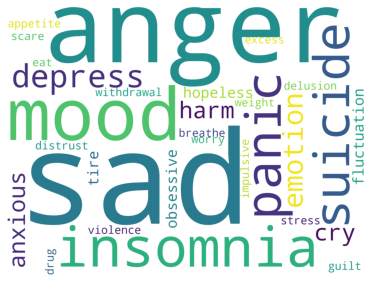

In [205]:
vectorizer.word_cloud(false_nonbipolar)

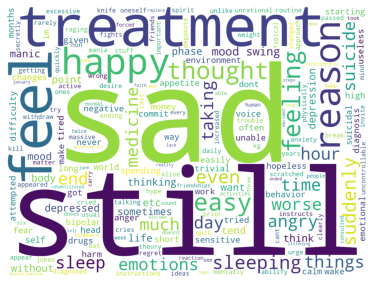

In [206]:
vectorizer.word_cloud_symptomps(false_nonbipolar)

### Sebenarnya Non Bipolar tapi diprediksi bipolar

In [207]:
print("Jumlah", false_bipolar.shape[0])
vectorizer.print_words(false_bipolar)

Jumlah 4
{'sad': 3, 'harm': 2, 'obsessive': 2, 'suicide': 2, 'cry': 2, 'depress': 2, 'mood': 2, 'fluctuation': 2, 'libido': 1, 'emotion': 1, 'withdrawal': 1, 'stress': 1, 'insomnia': 1, 'eat': 1, 'guilt': 1, 'impulsive': 1, 'distrust': 1, 'anger': 1, 'violence': 1, 'panic': 1, 'numb': 1}


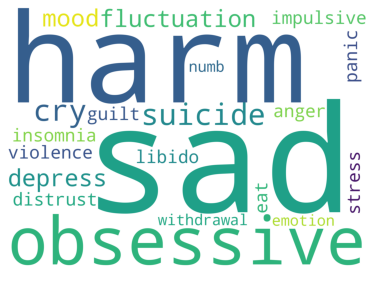

In [208]:
vectorizer.word_cloud(false_bipolar)

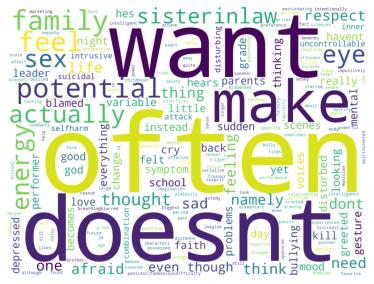

In [209]:
vectorizer.word_cloud_symptomps(false_bipolar)

### Benar prediksi bipolar

In [210]:
print("Jumlah", true_bipolar.shape[0])
vectorizer.print_words(true_bipolar)

Jumlah 6
{'depress': 4, 'suicide': 4, 'delusion': 3, 'insomnia': 3, 'eat': 2, 'anger': 2, 'fluctuation': 2, 'mood': 2, 'emotion': 2, 'impulsive': 2, 'weight': 2, 'violence': 1, 'withdrawal': 1, 'hatred': 1, 'harm': 1, 'guilt': 1, 'nausea': 1, 'tire': 1, 'panic': 1, 'heartbeat': 1, 'faint': 1, 'drug': 1, 'dizzy': 1, 'cry': 1, 'anxious': 1, 'headache': 1}


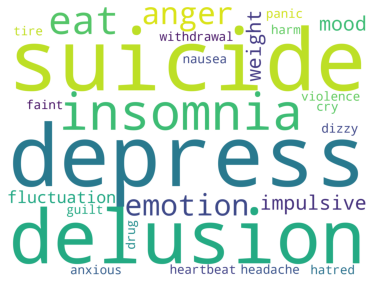

In [211]:
vectorizer.word_cloud(true_bipolar)

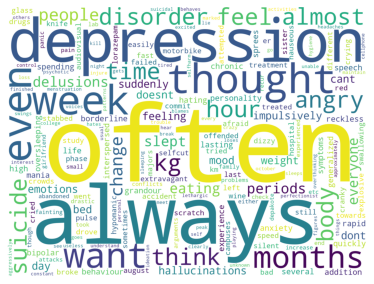

In [212]:
vectorizer.word_cloud_symptomps(true_bipolar)

### Benar prediksi non bipolar

In [154]:
print("Jumlah", true_nonbipolar.shape[0])
vectorizer.print_words(true_nonbipolar)

Jumlah 129
{'insomnia': 41, 'anxious': 31, 'sad': 26, 'panic': 26, 'concentrate': 20, 'anger': 17, 'cry': 16, 'nausea': 13, 'emotion': 12, 'tire': 12, 'breathe': 12, 'dizzy': 11, 'headache': 10, 'appetite': 10, 'eat': 10, 'suicide': 9, 'sweat': 8, 'mood': 8, 'worry': 8, 'obsessive': 7, 'guilt': 7, 'lonely': 7, 'heartbeat': 7, 'forget': 7, 'excess': 7, 'withdrawal': 6, 'harm': 5, 'alcohol': 5, 'tremble': 5, 'stress': 5, 'violence': 5, 'depress': 4, 'empty': 4, 'fluctuation': 4, 'distrust': 4, 'weight': 4, 'confuse': 3, 'hopeless': 3, 'lazy': 3, 'delusion': 3, 'numb': 2, 'digestive': 2, 'balance': 2, 'faint': 2, 'communicate': 2, 'impulsive': 1, 'respond': 1, 'trauma': 1, 'drug': 1, 'paranoia': 1, 'overreact': 1, 'libido': 1, 'addict': 1, 'echolalia': 1, 'hatred': 1, 'bulimia': 1}


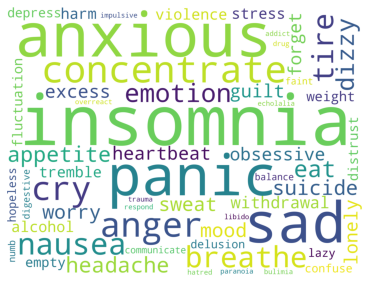

In [213]:
vectorizer.word_cloud(true_nonbipolar)

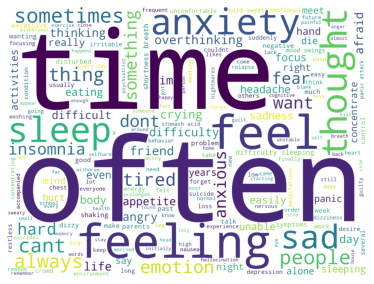

In [214]:
vectorizer.word_cloud_symptomps(true_nonbipolar)